# Russell Demo
Russell allows you to approximate RZ gates with typically 30-70% fewer T gates, at the cost of needing non-deterministic circuits. This is a quick demo to get you started.

## Gridsynth baselines
Let's first generate some random angles at different precisions and see how the T cost scales. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import sys
sys.path.append('..')

import russell as rus

In [2]:
def tcost_gridsynth(angle, d_prec=5):
    # This function calculates the cost of the Gridsynth
    # for a given angle of the grid
    
    # assert type(d_prec) is int, "d_prec must be an integer"
    assert type(angle) is str, "angle must be a string"
    
    gs_output = subprocess.run(['./gridsynth.exe', angle, "-d", str(d_prec)], capture_output=True, text=True)
    
    return gs_output.stdout.count("T")

In [3]:
# using this method, let's now compute the average cost of Gridsynth as precision increases

angle_set = [f"pi/{2**k}" for k in range(3, 10)] # use Fourier angles
angle_set += [f"{np.random.rand()*np.pi}" for _ in range(10)] # use random angles

d_prec_set = np.array(list(range(2, 20, 1)), dtype=np.int64)

In [4]:
costs = np.zeros((len(angle_set), len(d_prec_set)))

for angle_idx, angle in enumerate(angle_set):
    for d_prec_idx, d_prec in enumerate(d_prec_set):
        costs[angle_idx, d_prec_idx] = tcost_gridsynth(angle, d_prec)

Slope: 10.137072785770654, Intercept: -1.4196564074546827


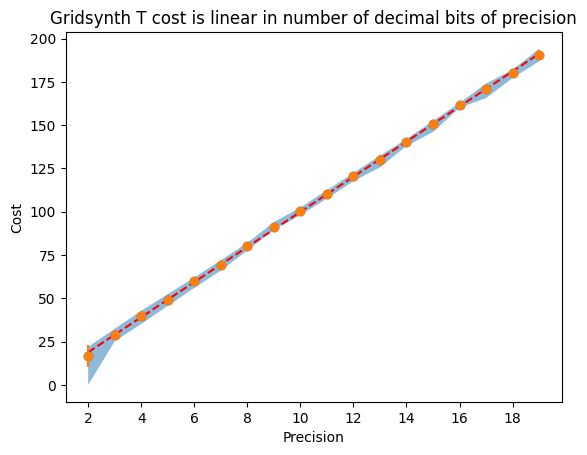

In [5]:

# compute avg, percentiles, etc.
avg_costs = np.mean(costs, axis=0)
std_costs = np.std(costs, axis=0)
percentile_05 = np.percentile(costs, 5, axis=0)
percentile_95 = np.percentile(costs, 95, axis=0)

# plot the results
plt.fill_between(d_prec_set, percentile_05, percentile_95, alpha=0.5)
plt.errorbar(d_prec_set, avg_costs, yerr=std_costs, fmt='o')
plt.xlabel("Precision")
plt.xticks(d_prec_set[::2])
plt.ylabel("Cost")
plt.title("Gridsynth T cost is linear in number of decimal bits of precision")

# add a trendline
slope, intercept = np.polyfit(d_prec_set, avg_costs, 1)
plt.plot(d_prec_set, slope*d_prec_set + intercept, 'r--')
plt.errorbar(d_prec_set, avg_costs, yerr=std_costs, fmt='o')

# show parameters
print(f"Slope: {slope}, Intercept: {intercept}")

## Comparing to Russell
Our results show that Gridsynth can produce high precision angles, albeit at high depth. For 1e-20 precision angles, this requires about 200 T gates, which is incredibly onerous. We will reduce this dramatically via russell. 

Russell adds a new parameter: failure probability. The synthesis scheme may fail; we can set this maximum tolerable failure probability.

For our experiments, we will set this to be 0.1%, a small likelihood, but this can be tuned later. 

In [6]:
def tcost_rus(angle, d_prec=5, fail_prob=1e-3):
    seq = rus.search.synthesize(angle, d_prec, fail_prob)
    return seq.count("T")

In [7]:
# let's again collect data for russell

costs_russell = np.zeros((len(angle_set), len(d_prec_set)))

for angle_idx, angle in enumerate(angle_set):
    for d_prec_idx, d_prec in enumerate(d_prec_set):
        costs_russell[angle_idx, d_prec_idx] = tcost_rus(angle, d_prec)

c:\Users\keepw\Documents\Research\sqc\demos\..\russell\ma_synthesis.py:180: ComplexWarning: Casting complex values to real discards the imaginary part
  hat_U[:, 0] = get_xyz_int(U @ FLOAT_GATE_LOOKUP["X"] @ Udag)
c:\Users\keepw\Documents\Research\sqc\demos\..\russell\ma_synthesis.py:181: ComplexWarning: Casting complex values to real discards the imaginary part
  hat_U[:, 1] = get_xyz_int(U @ FLOAT_GATE_LOOKUP["Y"] @ Udag)
c:\Users\keepw\Documents\Research\sqc\demos\..\russell\ma_synthesis.py:182: ComplexWarning: Casting complex values to real discards the imaginary part
  hat_U[:, 2] = get_xyz_int(U @ FLOAT_GATE_LOOKUP["Z"] @ Udag)


Slope: 10.137072785770654, Intercept: -1.4196564074546827
Slope: 3.4189279426941055, Intercept: 9.0032173860256


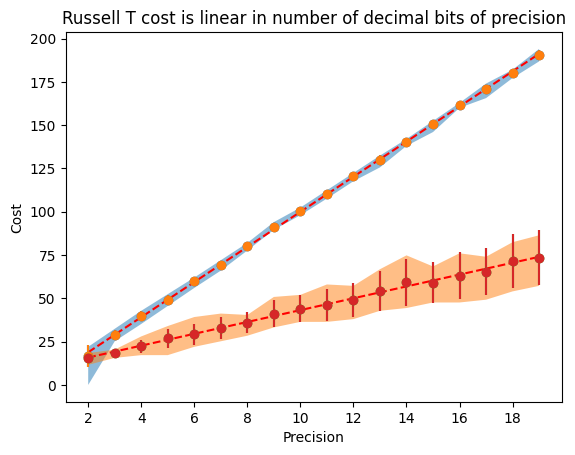

In [8]:
# let's now compare the plots again
avg_rus_costs = np.mean(costs_russell, axis=0)
std_rus_costs = np.std(costs_russell, axis=0)
percentile_05_rus = np.percentile(costs_russell, 5, axis=0)
percentile_95_rus = np.percentile(costs_russell, 95, axis=0)

# old plot ------
plt.fill_between(d_prec_set, percentile_05, percentile_95, alpha=0.5)
plt.errorbar(d_prec_set, avg_costs, yerr=std_costs, fmt='o')
plt.xlabel("Precision")
plt.xticks(d_prec_set[::2])
plt.ylabel("Cost")
plt.title("Gridsynth T cost is linear in number of decimal bits of precision")

# add a trendline
slope, intercept = np.polyfit(d_prec_set, avg_costs, 1)
plt.plot(d_prec_set, slope*d_prec_set + intercept, 'r--')
plt.errorbar(d_prec_set, avg_costs, yerr=std_costs, fmt='o')

# show parameters
print(f"Slope: {slope}, Intercept: {intercept}")

# new plot -----
plt.fill_between(d_prec_set, percentile_05_rus, percentile_95_rus, alpha=0.5)
plt.errorbar(d_prec_set, avg_rus_costs, yerr=std_rus_costs, fmt='o')
plt.xlabel("Precision")
plt.xticks(d_prec_set[::2])
plt.ylabel("Cost")
plt.title("Russell T cost is linear in number of decimal bits of precision")

# add a trendline
slope_rus, intercept_rus = np.polyfit(d_prec_set, avg_rus_costs, 1)
plt.plot(d_prec_set, slope_rus*d_prec_set + intercept_rus, 'r--')
plt.errorbar(d_prec_set, avg_rus_costs, yerr=std_rus_costs, fmt='o')

# show parameters
print(f"Slope: {slope_rus}, Intercept: {intercept_rus}")

## Russell as a continuous version of Gridsynth
Now, we fix the approximation precision and instead vary the failure probability, showing that RUS can be thought of as a continuous version of Gridsynth in this parameter space. 

In [11]:
precision_idx = 5
set_precision = d_prec_set[precision_idx]
print(f"Gridsynth cost at precision {set_precision}: {avg_costs[precision_idx]}")

Gridsynth cost at precision 7: 69.05882352941177


In [42]:

# let's again collect data for russell

prob_values = np.logspace(-13, -3, 20 - 3 + 1)

costs_russell_byprob = np.zeros((len(angle_set), len(prob_values)))

for angle_idx, angle in enumerate(angle_set):
    for prob_idx, fail_prob in enumerate(prob_values):
        costs_russell_byprob[angle_idx, prob_idx] = tcost_rus(angle, set_precision, fail_prob)

c:\Users\keepw\Documents\Research\sqc\demos\..\russell\ma_synthesis.py:180: ComplexWarning: Casting complex values to real discards the imaginary part
  hat_U[:, 0] = get_xyz_int(U @ FLOAT_GATE_LOOKUP["X"] @ Udag)
c:\Users\keepw\Documents\Research\sqc\demos\..\russell\ma_synthesis.py:181: ComplexWarning: Casting complex values to real discards the imaginary part
  hat_U[:, 1] = get_xyz_int(U @ FLOAT_GATE_LOOKUP["Y"] @ Udag)
c:\Users\keepw\Documents\Research\sqc\demos\..\russell\ma_synthesis.py:182: ComplexWarning: Casting complex values to real discards the imaginary part
  hat_U[:, 2] = get_xyz_int(U @ FLOAT_GATE_LOOKUP["Z"] @ Udag)


In [31]:
# compute the average of the gridsynth, russell cost for fixed precision
avg_gs_cost = np.mean(costs[:, precision_idx])
avg_rus_cost = np.mean(costs_russell_byprob, axis=0)

Text(0.5, 1.0, 'Russell is robust to failure probability')

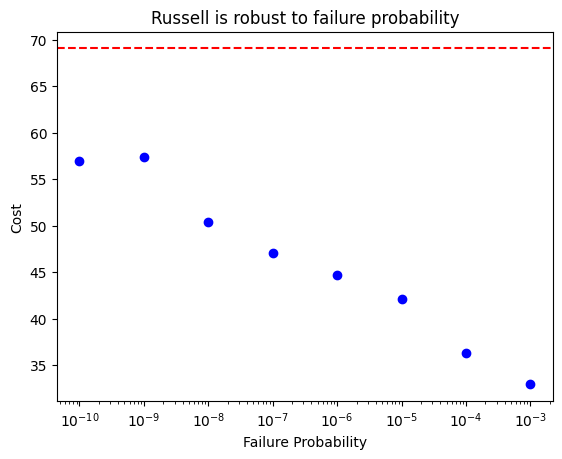

In [36]:
# plot this
# plt.plot([0], [avg_gs_cost], 'ro', label="Gridsynth")
plt.plot(prob_values, avg_rus_cost, 'bo', label="Russell")

# hline
plt.axhline(y=avg_gs_cost, color='r', linestyle='--', label="Gridsynth")

plt.xscale('log')
plt.xlabel("Failure Probability")
plt.ylabel("Cost")
plt.title("Russell is robust to failure probability")